In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd


In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc



In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [8]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables|
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# Test code to see if I can read rows of data successfully
for row in session.query(Measurement, Measurement.tobs).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x0000025C74E61A88>, 65.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000025C74E5DE08>, 63.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000025C75561AC8>, 74.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000025C75561448>, 76.0)
(<sqlalchemy.ext.automap.measurement object at 0x0000025C75561C08>, 73.0)


In [ ]:
# Bring in current date and find start date for "last 12 months".
# Ended up not being needed since data set only through August 2017.  However, could use this to get dates.

#current_date=dt.datetime.today().strftime("%m/%d/%Y")
#print(current_date)
#period =  dt.datetime.today() - pd.Timedelta('365 days')
#start_date=period.strftime("%m/%d/%Y")
#print(start_date)

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation in inches')

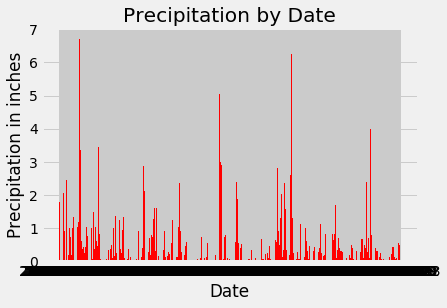

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_row = session.query(Measurement).order_by(Measurement.date.desc()).first()
lastrow_convert = dt.datetime.strptime(last_row.date, '%Y-%m-%d')
end_date=lastrow_convert
# Subtract 365 days
start_date = lastrow_convert - pd.Timedelta('365 days')
#Convert back to format that data table is using for query purposes
start_date_conv=dt.datetime.strftime(start_date, '%Y-%m-%d')
start_date_conv
                                     

# Perform a query to retrieve the data and precipitation scores

precip=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date_conv).filter(Measurement.date <= last_row.date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)
precip_df.set_index('date')

# Sort the dataframe by date
# Already sorted above when used the 'order_by' command.  However, if we wanted to sort the dataframe, use code below.
precip_df=precip_df.sort_values('date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis=precip_df['date']
y_axis=precip_df['prcp']


# fig=px.bar(precip_df,'date','prcp')
# fig.show()
plt.bar(x_axis, y_axis, color='r', align="center")


plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation in inches")


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#General Stats
precip_count=precip_df['prcp'].count()
precip_mean=precip_df['prcp'].mean()
precip_std=precip_df['prcp'].std()
#Calculate IRQ for precipitation
precip_quartile=precip_df['prcp'].quantile([.25, .5, .75])
precip_lowerq = precip_quartile[.25]
precip_mid = precip_quartile[.5]
precip_upperq = precip_quartile[.75]
precip_iqr =precip_upperq-precip_lowerq
#Precipitation max and min values
precip_min_vol=precip_df['prcp'].min()
precip_max_vol=precip_df['prcp'].max()
# set up bounds for outlier table.  Use 1.5*IQR value calculated above
precip_lower_bound = precip_lowerq - (1.5*precip_iqr)
precip_upper_bound = precip_upperq + (1.5*precip_iqr)
# Create new dataframe with information compiled above
precip_data=[['Count', precip_count],['Mean', precip_mean], ['Stdev', precip_std],['Mins', precip_min_vol ], ['25%', precip_lowerq ],['50%', precip_mid], ['75%', precip_upperq],['Max', precip_max_vol]]
precip_data_df=pd.DataFrame(precip_data, columns = ['Stat', 'Precipitation'])
precip_data_df

,Stat,Precipitation
0,Count,2021.000000
1,Mean,0.177279
2,Stdev,0.461190
3,Mins,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,Max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
# This will find total number of stations
station_count=session.query(Measurement).group_by(Measurement.station).count()
station_count

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_inf = session.query(Measurement.station,  
                    func.count(Measurement.station).label("total_count"),
                    )
station_inf = station_inf.group_by(Measurement.station).order_by(desc("total_count"))
station_inf.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_rain = session.query(Measurement.station.label("station"), func.min(Measurement.tobs).label("lowest temp"),
                            func.max(Measurement.tobs).label("highest temp"),
                            func.avg(Measurement.tobs).label("average temp"),
                            func.count(Measurement.station).label("total_count"),
                    )
station_rain = station_rain.group_by(Measurement.station).order_by(desc("total_count"))
print(station_rain[0])

('USC00519281', 54.0, 85.0, 71.66378066378067, 2772)


Text(0.5, 1.0, 'Temperature Histogram')

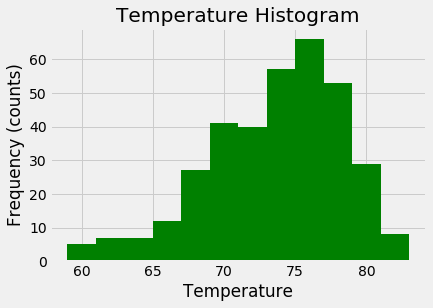

In [18]:
# Choose the station with the highest number of temperature observations.
var=station_rain[0][0]
var
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_temp=session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == var).filter(Measurement.date >= start_date_conv).filter(Measurement.date <= last_row.date).order_by(Measurement.date).all()
station_temp
station_temp_df=pd.DataFrame(station_temp)
# station_temp_df.set_index('date')
# precip_df=precip_df.sort_values('date', ascending=True)
temps=station_temp_df['tobs']
plt.hist(temps,bins=12, color='green')
plt.xlabel('Temperature')
plt.ylabel('Frequency (counts)')
plt.title('Temperature Histogram')

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
